In [1]:
# pip install cufflinks

In [2]:
import pandas as pd
import numpy as np
from quantmod.markets import getData

import cufflinks as cf
cf.go_offline()
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Plotting
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 

In [3]:
# Step 1: 获取并保留Close列为新的DataFrame列
df1 = getData('GOVT.AX', period='YTD')[['Close']]
df2 = getData('VGB.AX', period='YTD')[['Close']]
df3 = getData('ILB.AX', period='YTD')[['Close']]

# Step 2: 重命名列，避免重名冲突
df1.rename(columns={'Close': 'GOVT'}, inplace=True)
df2.rename(columns={'Close': 'VGB'}, inplace=True)
df3.rename(columns={'Close': 'ILB'}, inplace=True)

# Step 3: 合并
df_temp = pd.merge(df1, df2, left_index=True, right_index=True)
df = pd.merge(df_temp, df3, left_index=True, right_index=True)

# Step 4: 计算 log return
df_all = np.log(df / df.shift(1)).dropna()

In [4]:
scaler = StandardScaler()

df_all_filled = df_all.ffill().bfill()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_all_filled),
    columns=df_all.columns,
    index=df_all.index
)
df_scaled = df_scaled.astype('float64')  # 强制转成 float64 类型


### **Covariance Matrix(Scaled Data)**

In [5]:
cov_array = np.cov(df_scaled,rowvar = False)
cov_df_scaled = pd.DataFrame(cov_array, columns = df_scaled.columns, index = df_scaled.columns)
cov_df_scaled.style.format('{:.4}')

,GOVT,VGB,ILB
GOVT,1.008,0.8677,0.7097
VGB,0.8677,1.008,0.6846
ILB,0.7097,0.6846,1.008


In [6]:
eigenvalues, eigenvectors = np.linalg.eig(cov_array)

# Sort values
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Format into DataFrame
df1_eigval = pd.DataFrame({"Eigenvalues": eigenvalues})
df1_eigvec = pd.DataFrame(eigenvectors)


In [7]:
df1_eigval['Var Explained'] = df1_eigval['Eigenvalues'] / np.sum(df1_eigval['Eigenvalues'])
df1_eigval.style.format({'Var Explained':'{:.2%}'})

,Eigenvalues,Var Explained
0,2.519311,83.28%
1,0.366056,12.10%
2,0.139633,4.62%


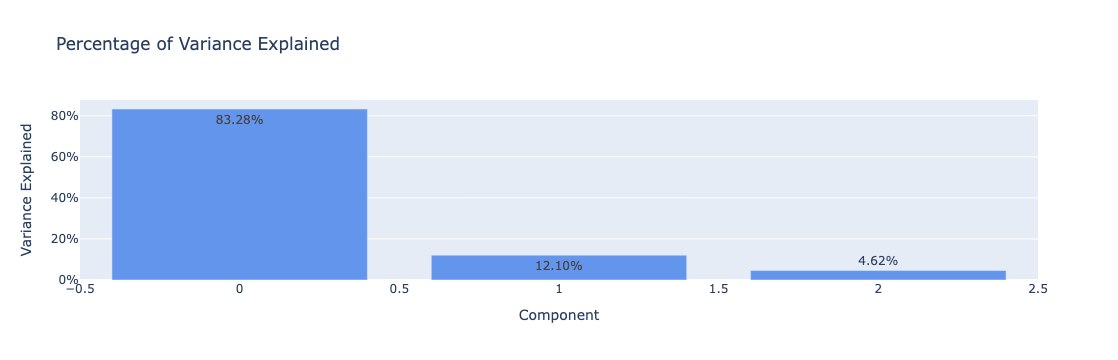

In [8]:
fig = px.bar(
    df1_eigval,
    y='Var Explained',
    text='Var Explained',
    labels={'index': 'Principal Component', 'Var Explained': '% Explained Variance'},
    title='Percentage of Variance Explained',
)
fig.update_traces(texttemplate='%{text:.2%}', marker_color='cornflowerblue')
fig.update_layout(yaxis_tickformat='.0%', xaxis_title='Component', yaxis_title='Variance Explained')
fig.show()

In [9]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=None)) 
])

pipe.fit(df_all)

# 主成分向量（即 eigenvectors）
components = pipe['pca'].components_

# 每个主成分的解释方差
explained_var = pipe['pca'].explained_variance_
explained_ratio = pipe['pca'].explained_variance_ratio_

In [11]:
components = pipe['pca'].components_

n_maturities = components.shape[1]
maturities = list(range(1, n_maturities + 1))  
pc_df = pd.DataFrame(components.T, columns=['PC1', 'PC2', 'PC3'], index=maturities)
pc_df.index.name = "Years"


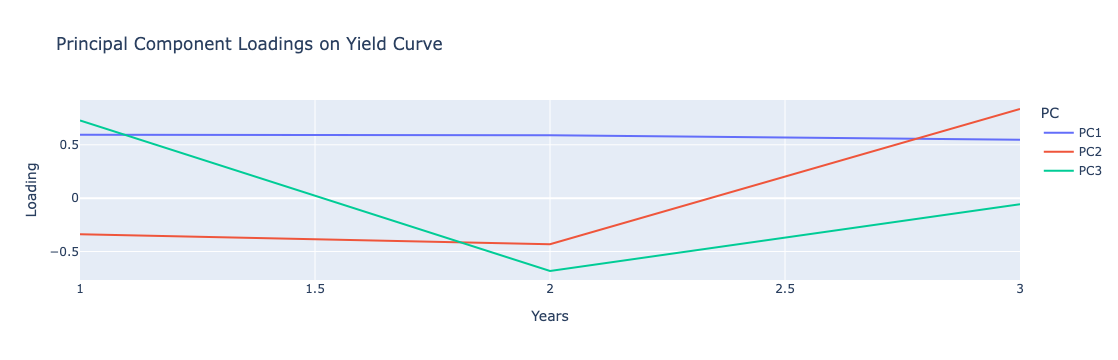

In [12]:
pc_df_reset = pc_df.reset_index().melt(id_vars='Years', var_name='PC', value_name='Loading')

fig = px.line(
    pc_df_reset,
    x='Years',
    y='Loading',
    color='PC',
    title='Principal Component Loadings on Yield Curve'
)
fig.show()

In [14]:
# 使用 PCA 模型中的 eigenvectors（即 components_）进行投影
eigenvectors = pipe['pca'].components_.T  # shape (n_features, n_components)


df_projection = pd.DataFrame(
    df_scaled.values.dot(pipe['pca'].components_.T),
    index=df_scaled.index,
    columns=['PC1', 'PC2', 'PC3']
)


In [15]:
df_projection

,PC1,PC2,PC3
Date,,,
2025-01-03,1.889652,0.036104,0.494276
2025-01-06,-2.763420,-0.184657,0.433436
2025-01-07,-0.603123,0.309329,-0.907581
2025-01-08,-0.780045,0.871416,0.091821
2025-01-09,0.095803,-0.459363,-0.049969
...,...,...,...
2025-06-23,0.203046,0.828829,0.255682
2025-06-24,2.149674,0.347129,-0.221899
2025-06-25,0.688352,-1.369061,0.167733


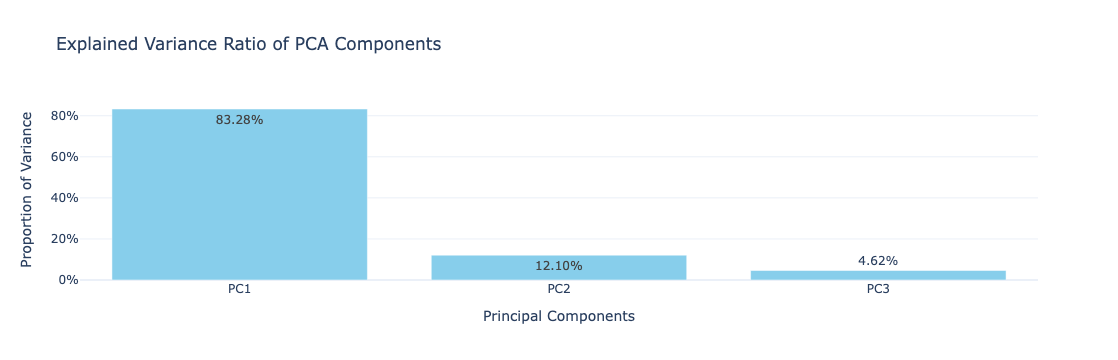

In [17]:
explained_var = pipe['pca'].explained_variance_ratio_

fig = go.Figure(data=[
    go.Bar(
        x=['PC1', 'PC2', 'PC3'],
        y=explained_var,
        text=[f'{v:.2%}' for v in explained_var],
        textposition='auto',
        marker_color='skyblue'
    )
])

fig.update_layout(
    title='Explained Variance Ratio of PCA Components',
    xaxis_title='Principal Components',
    yaxis_title='Proportion of Variance',
    yaxis_tickformat=".0%",
    template='plotly_white'
)

fig.show()

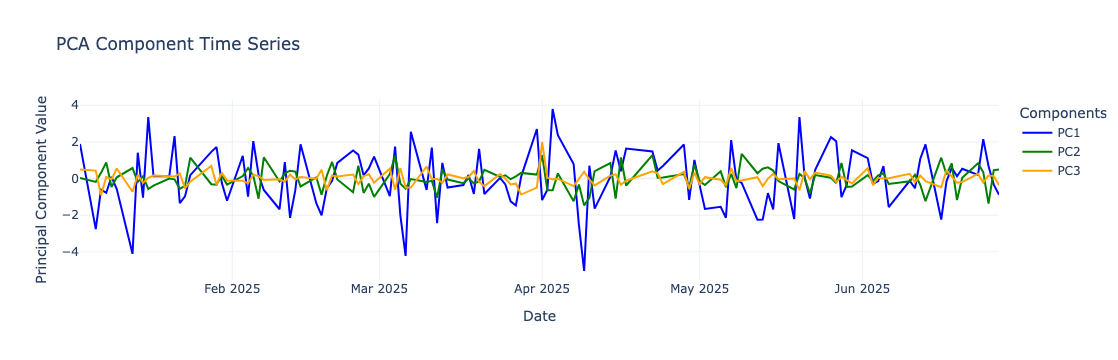

In [18]:
# 假设 df_projection 是你已有的 DataFrame，包含 Date 索引和 PC1, PC2, PC3 列
fig = go.Figure()

# 添加 PC1
fig.add_trace(go.Scatter(
    x=df_projection.index,
    y=df_projection['PC1'],
    mode='lines',
    name='PC1',
    line=dict(color='blue')
))

# 添加 PC2
fig.add_trace(go.Scatter(
    x=df_projection.index,
    y=df_projection['PC2'],
    mode='lines',
    name='PC2',
    line=dict(color='green')
))

# 添加 PC3
fig.add_trace(go.Scatter(
    x=df_projection.index,
    y=df_projection['PC3'],
    mode='lines',
    name='PC3',
    line=dict(color='orange')
))

# 更新图表布局
fig.update_layout(
    title='PCA Component Time Series',
    xaxis_title='Date',
    yaxis_title='Principal Component Value',
    legend_title='Components',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()
